## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import src.model_analysis.generation as gen
import src.model_analysis.logs as logs
import src.visualize as vis

2023-02-14 18:22:39.290539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 18:22:39.399641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 18:22:39.399671: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 18:22:40.104550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-1

In [2]:
base_path = '..'

## Generate Images for FID Calculation

In [3]:
datasets = ['train', 'test']
models = ['pix2pix', 'autopainter']
epochs = np.arange(10, 210, 10)

# gen.generate_images_from_dataset_epochs(datasets, models, epochs, base_path = base_path, save = True)

## Parse Loss Logs

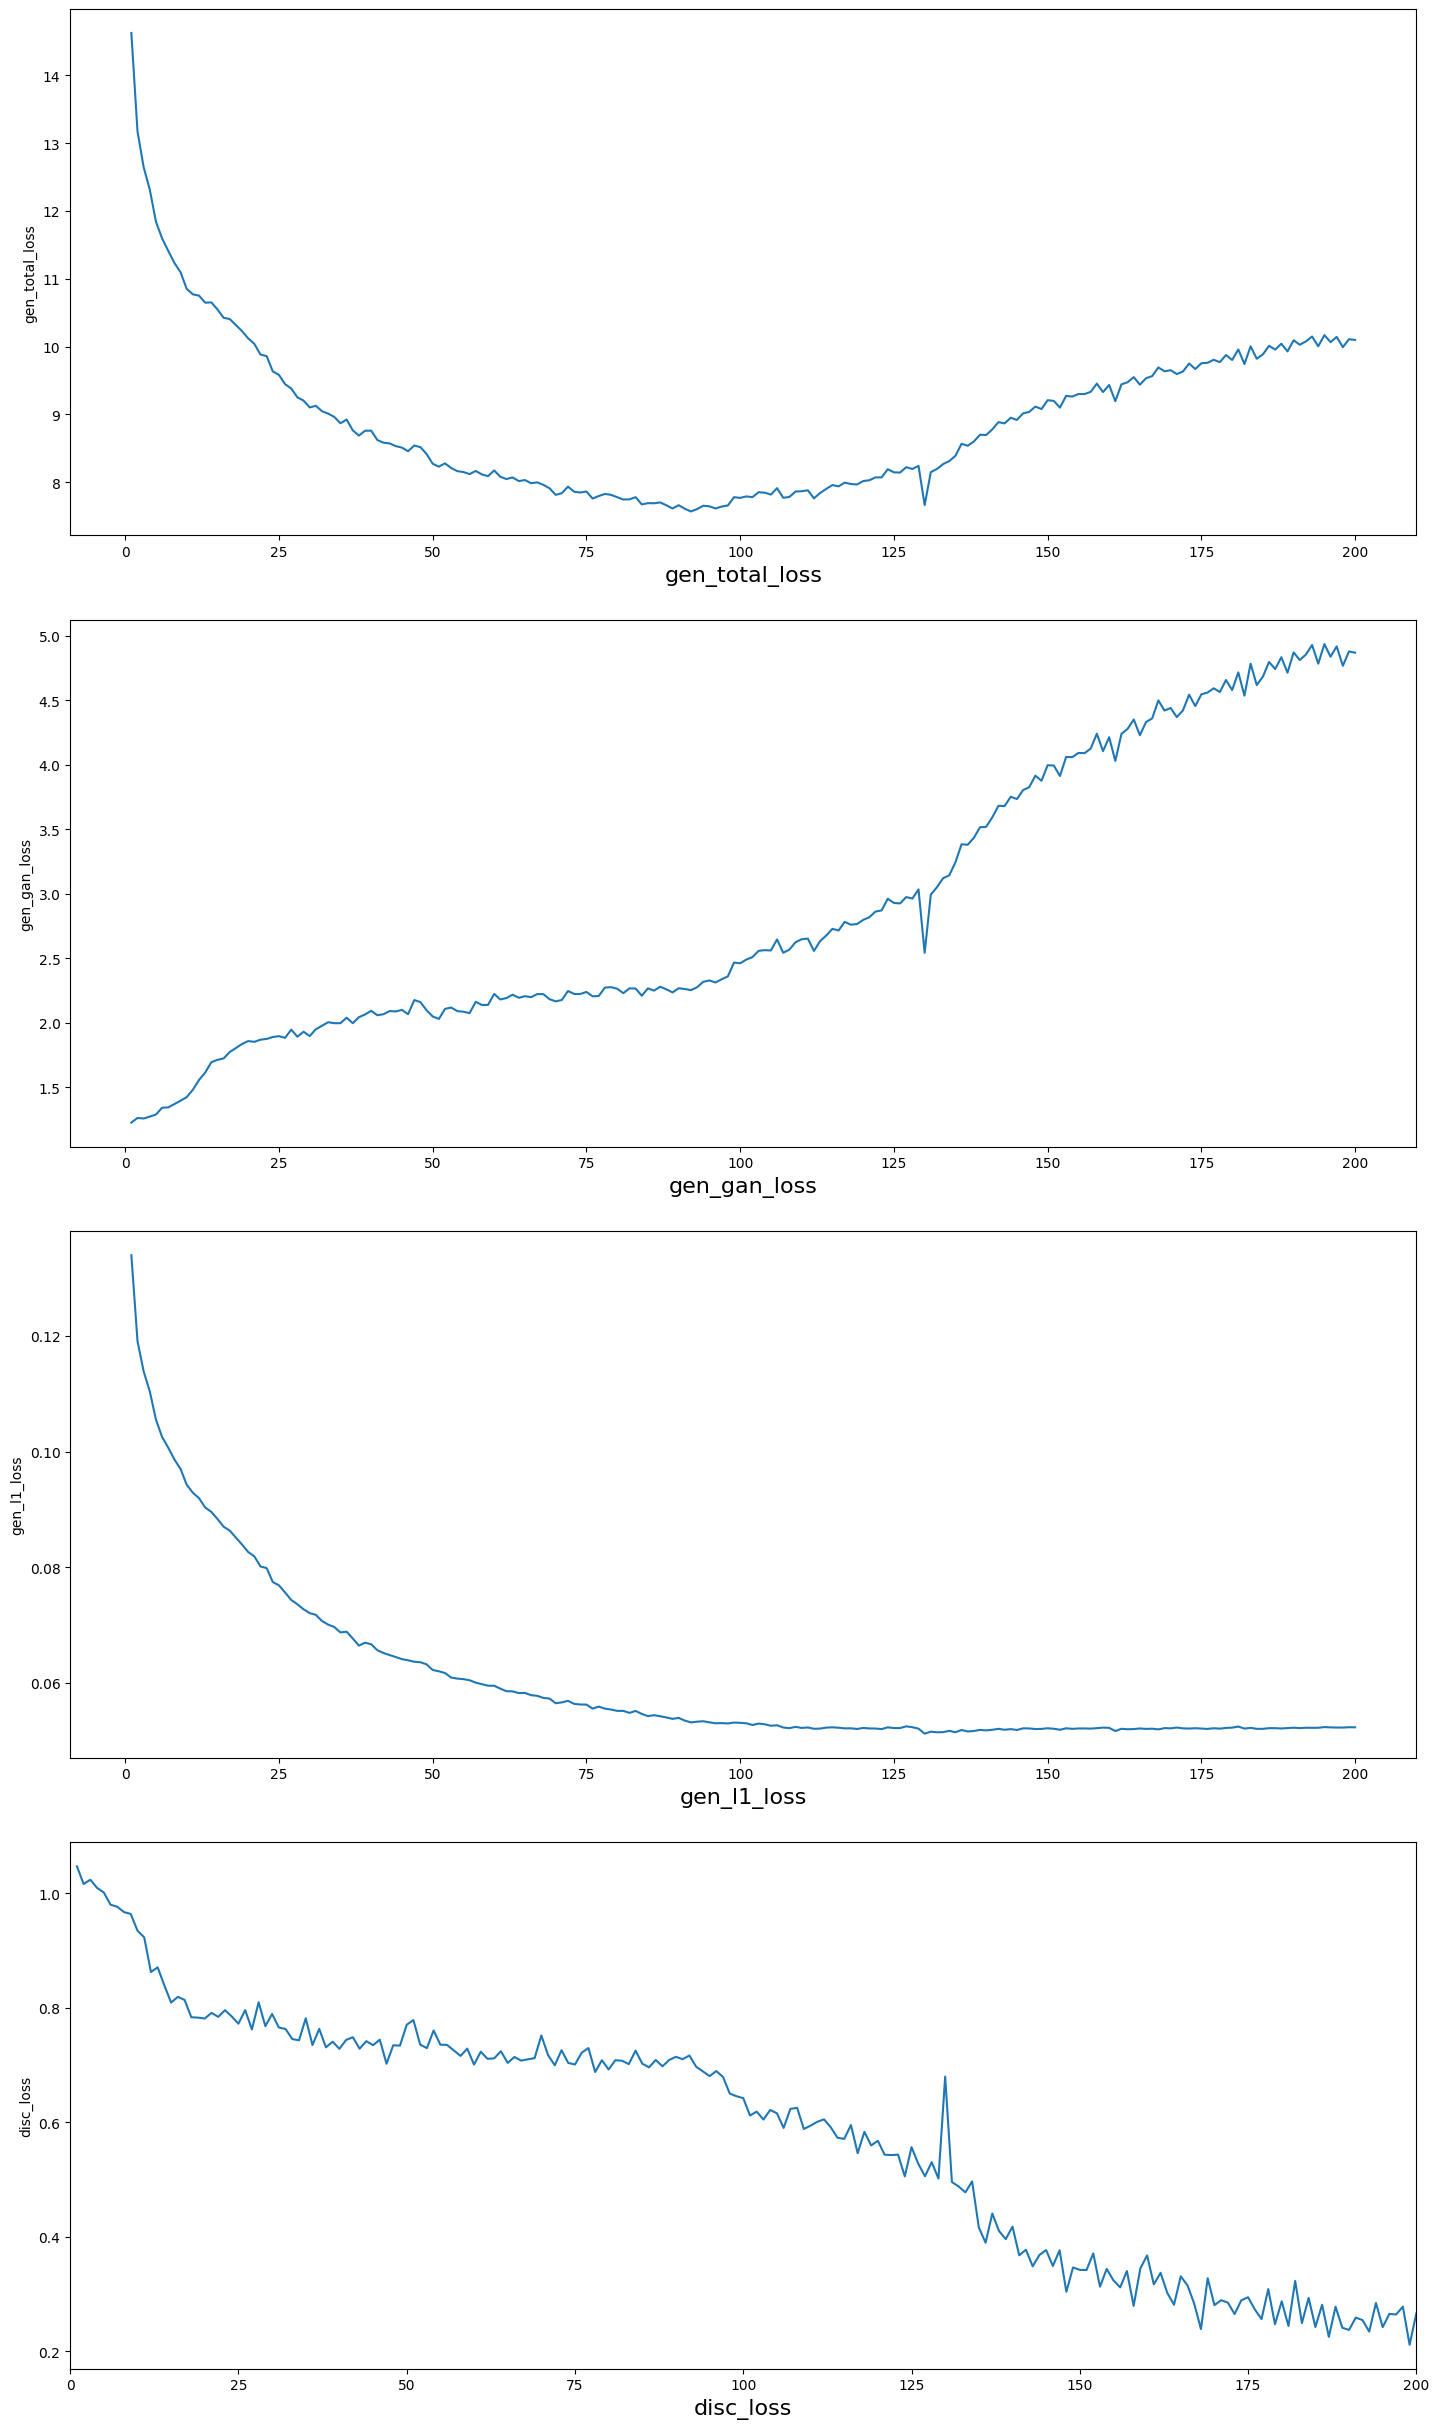

In [4]:
log_file = '../logs/pix2pix/epoch_data.csv'
columns = ['epoch', 'gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'disc_loss']
pix2pix_df = logs.parse_logs(log_file, columns, scale = True, plot = True)

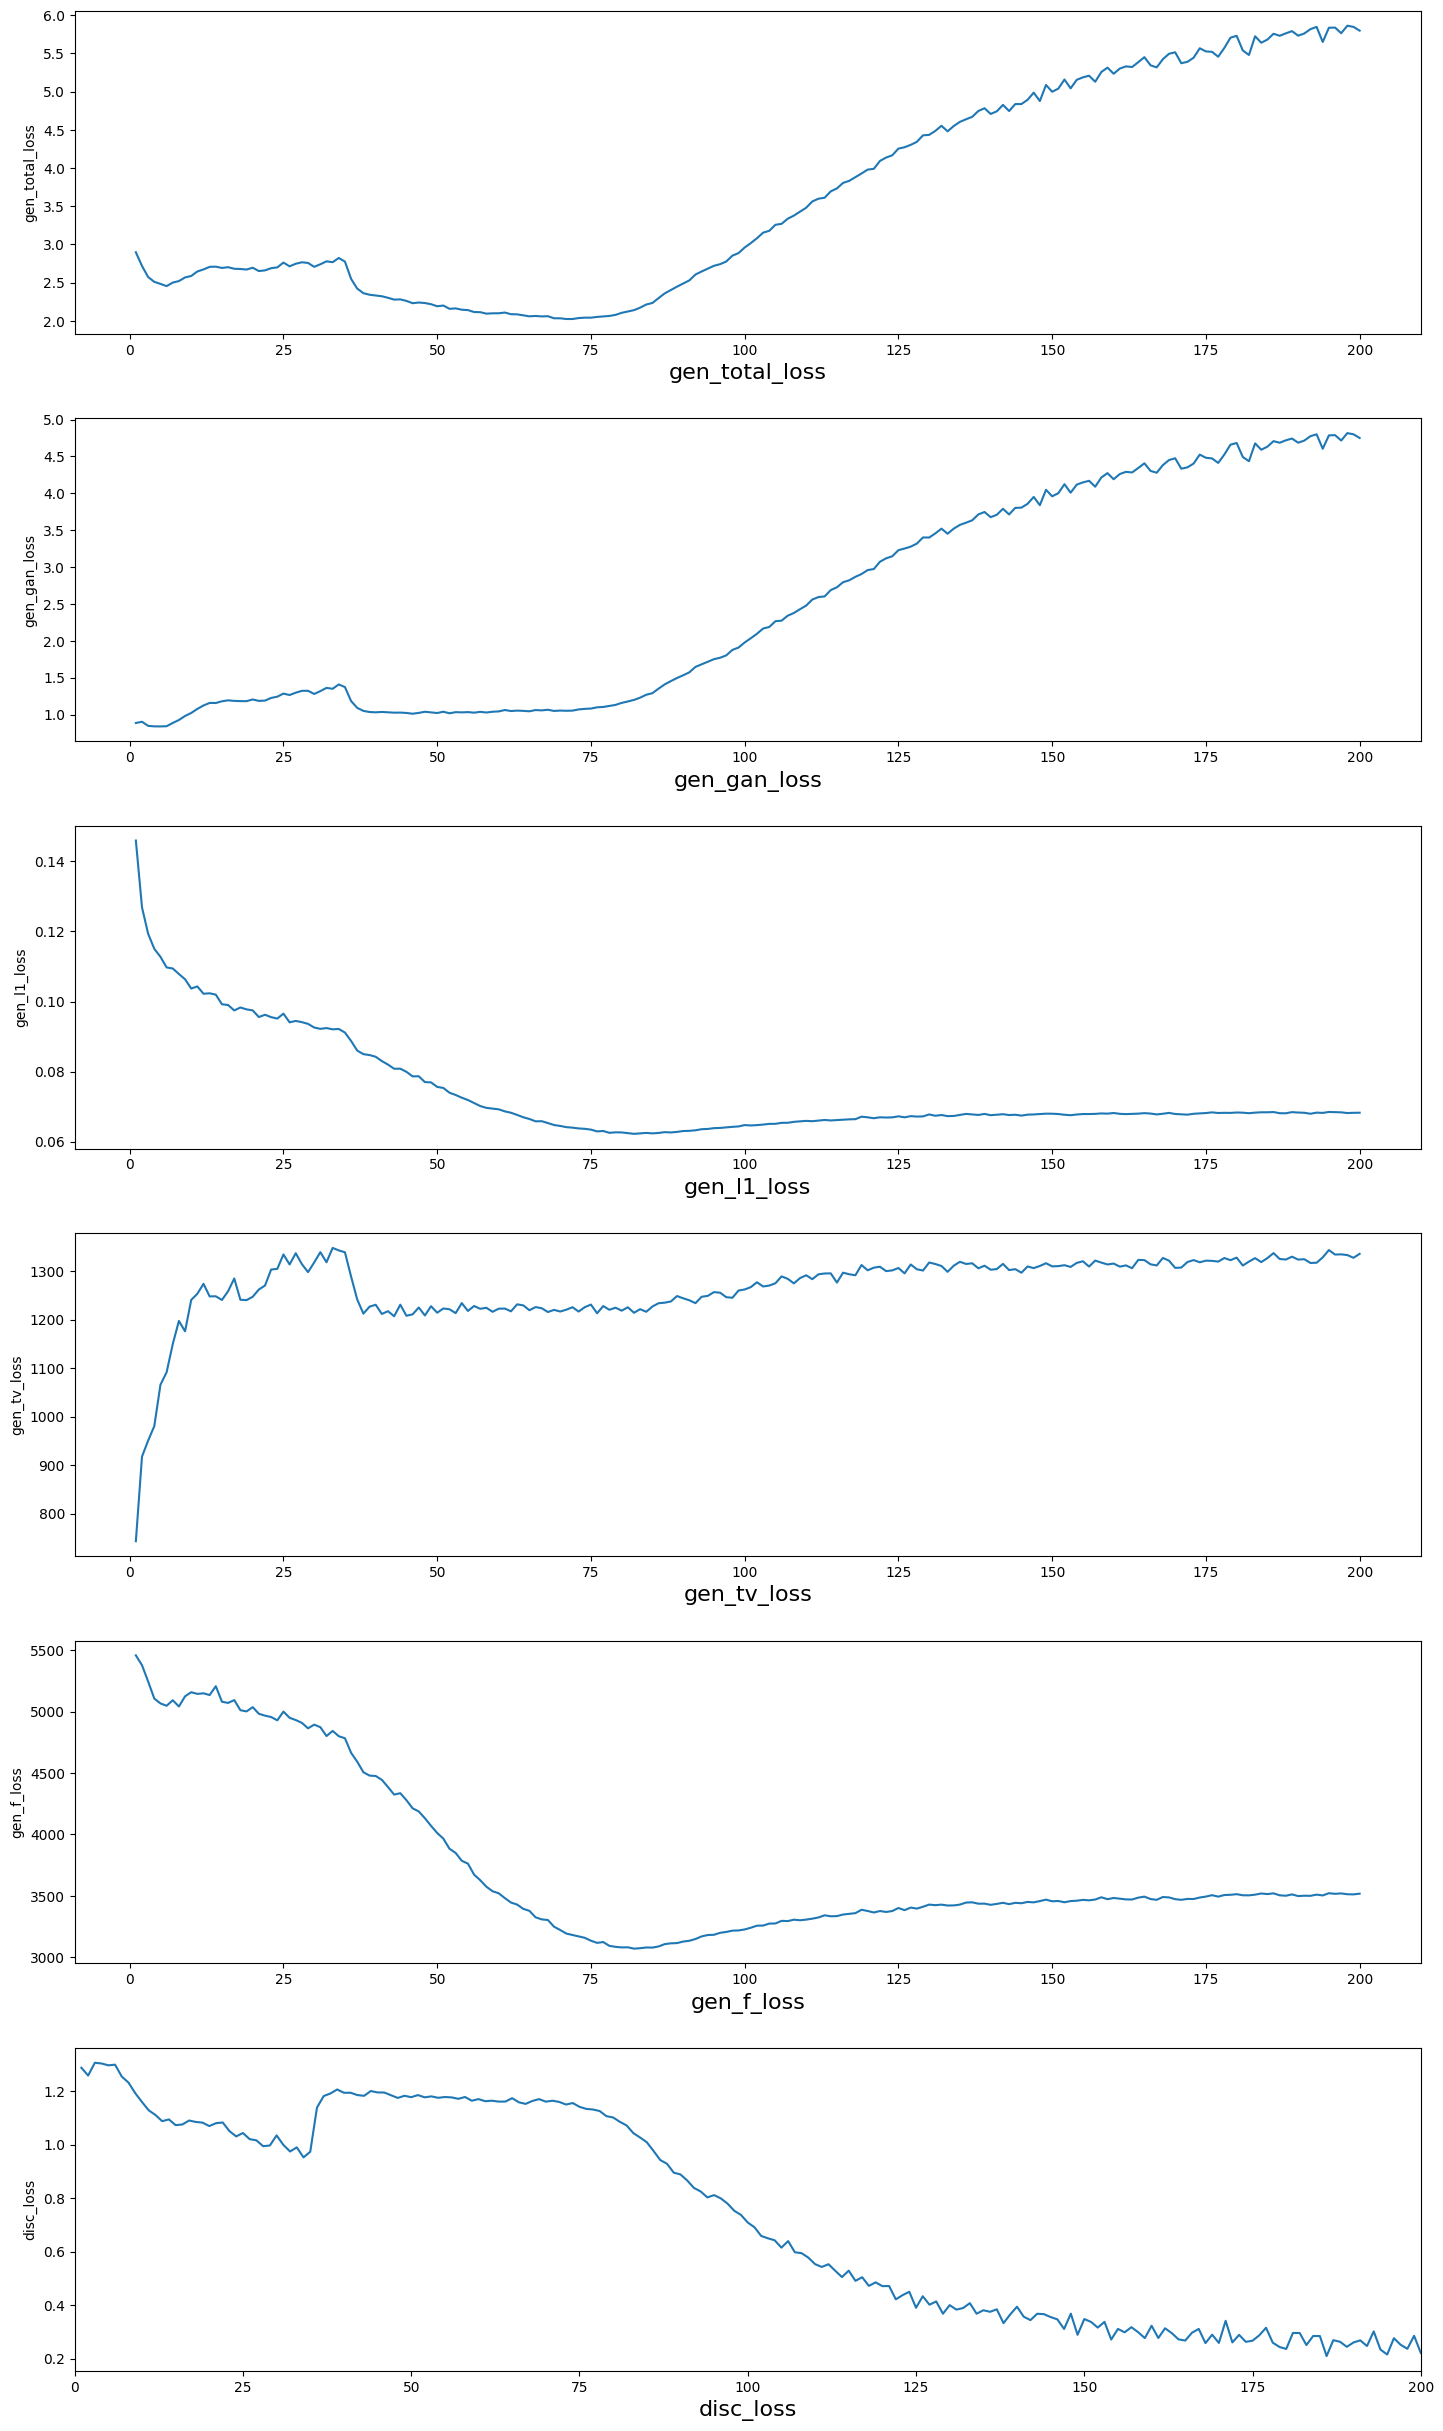

In [5]:
log_file = '../logs/autopainter/epoch_data.csv'
columns = ['epoch', 'gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'gen_tv_loss', 'gen_f_loss', 'disc_loss']
autopainter_df = logs.parse_logs(log_file, columns, scale = True, plot = True)

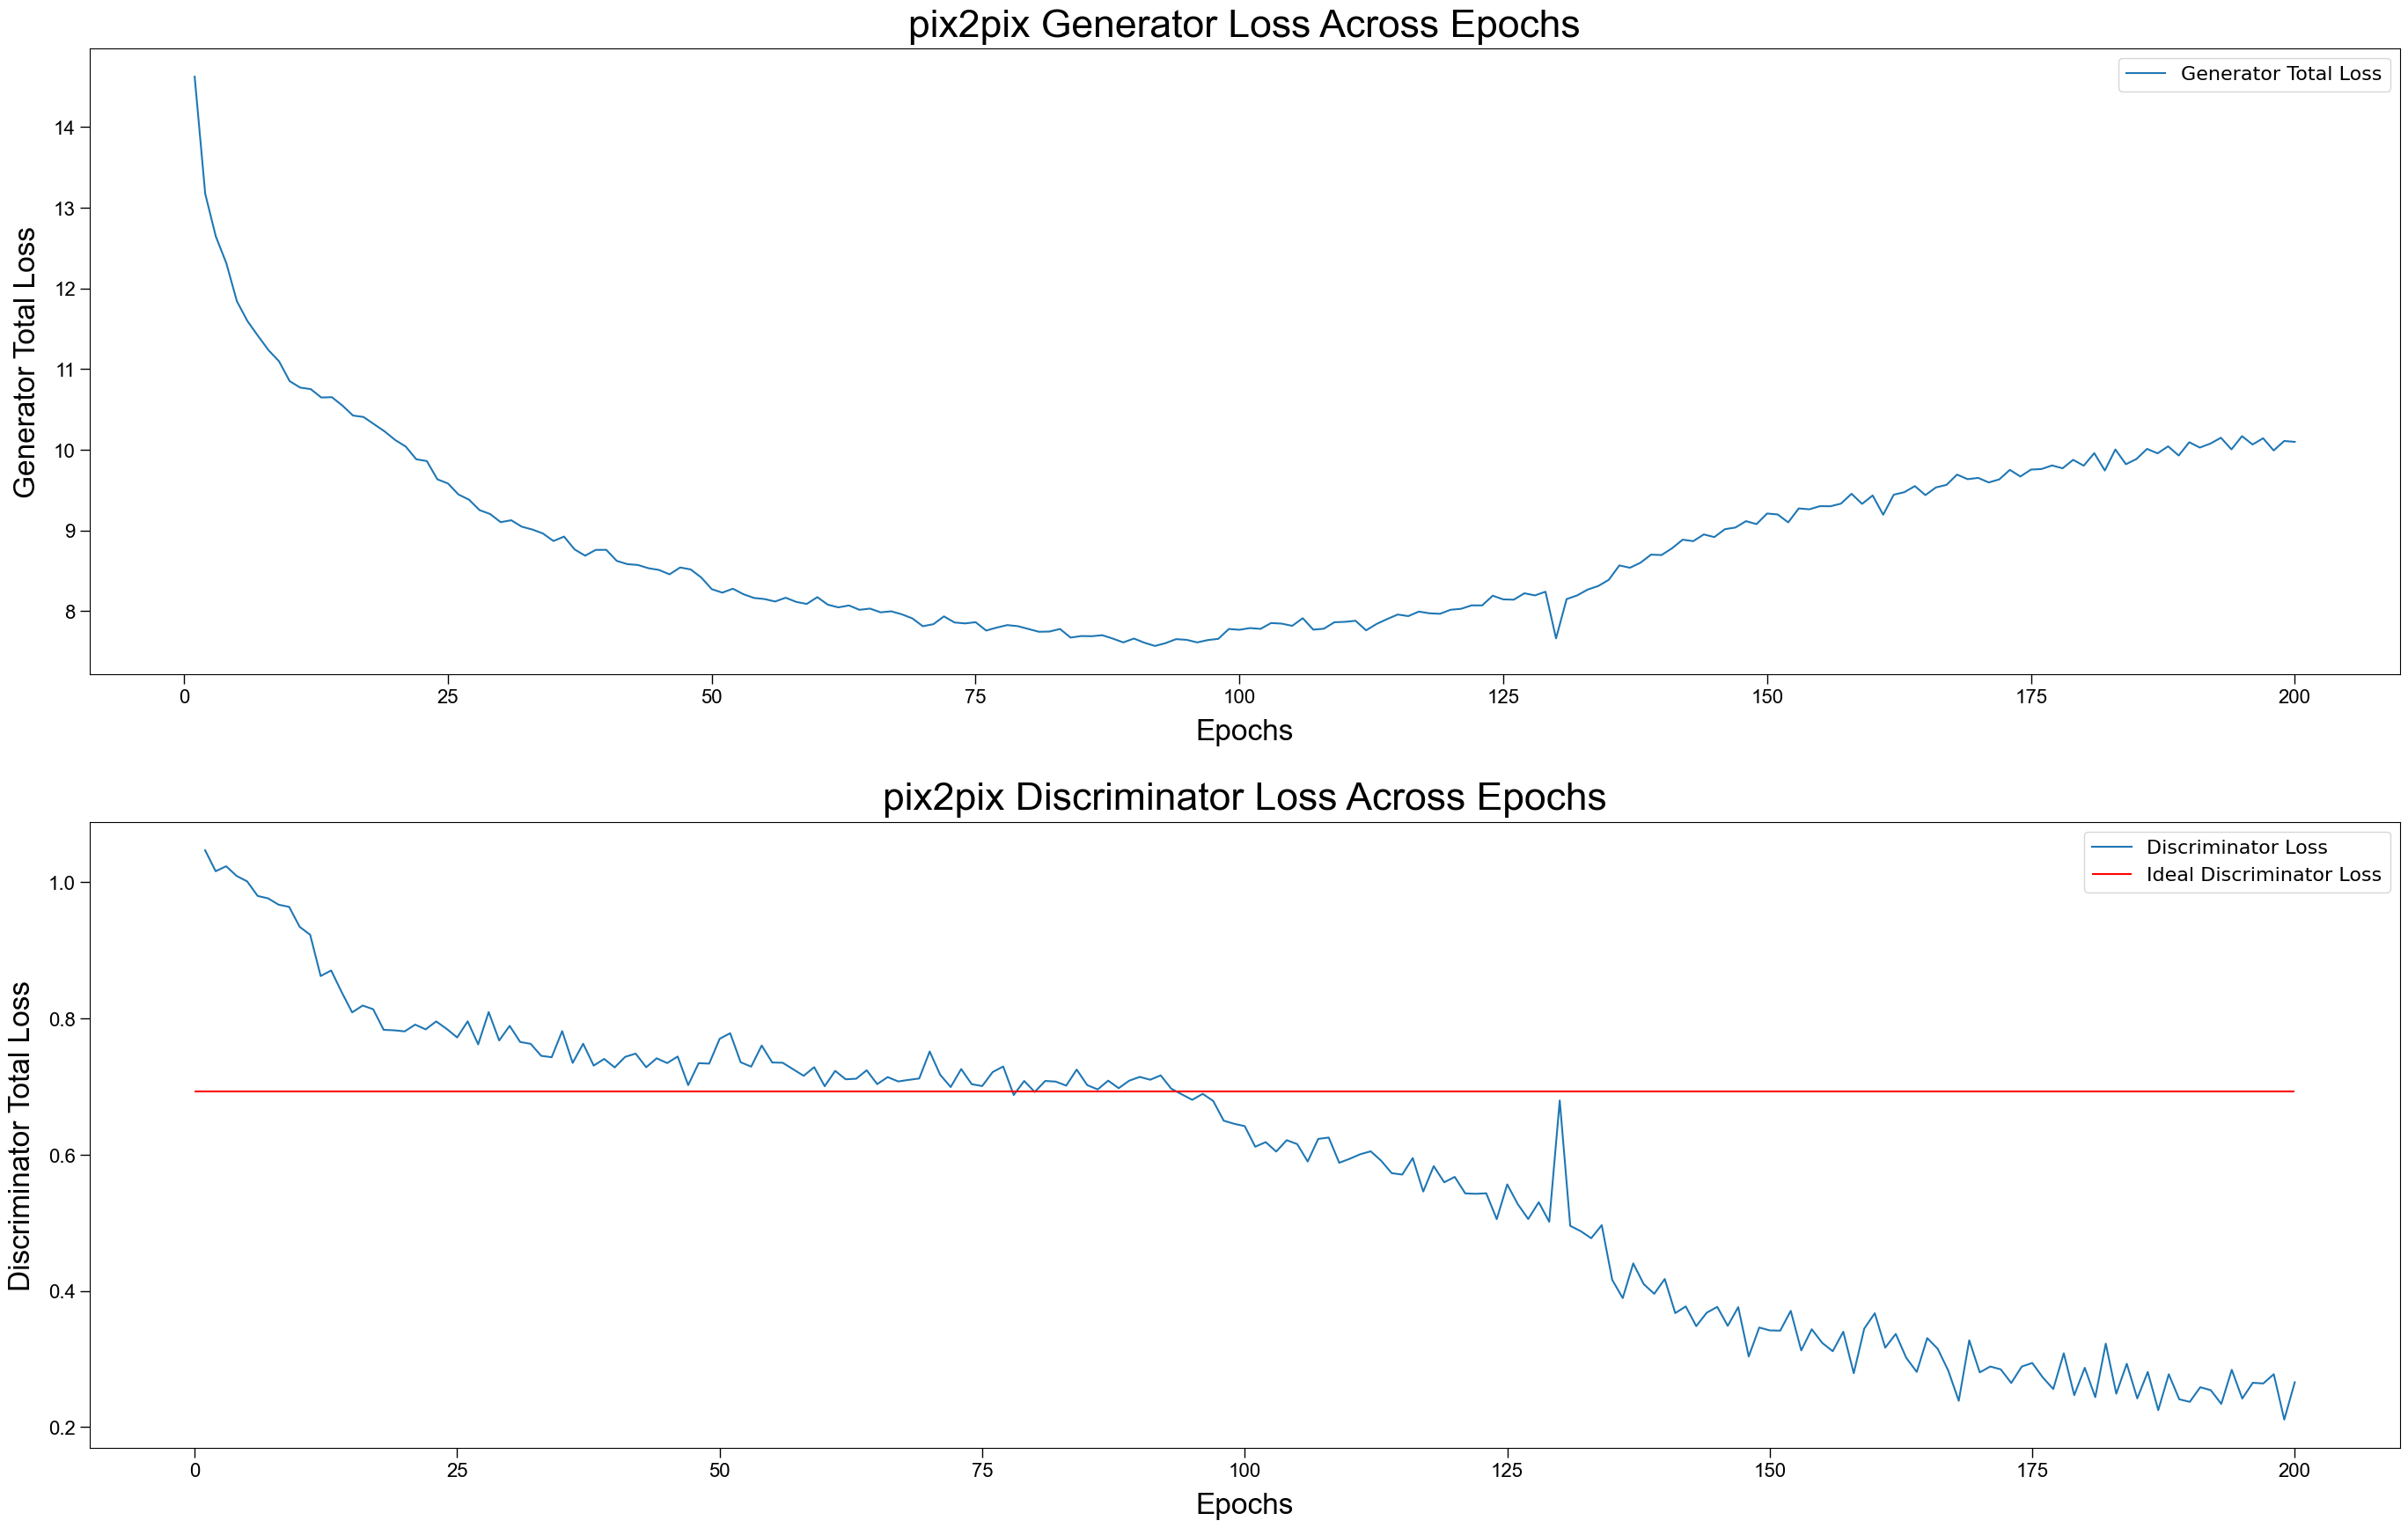

In [21]:
fig = vis.plot_gen_and_disc_losses(pix2pix_df, 'pix2pix')
# plt.savefig('../visualizations/model_health/pix2pix_losses.png', format = 'png', bbox_inches = 'tight')
plt.show()

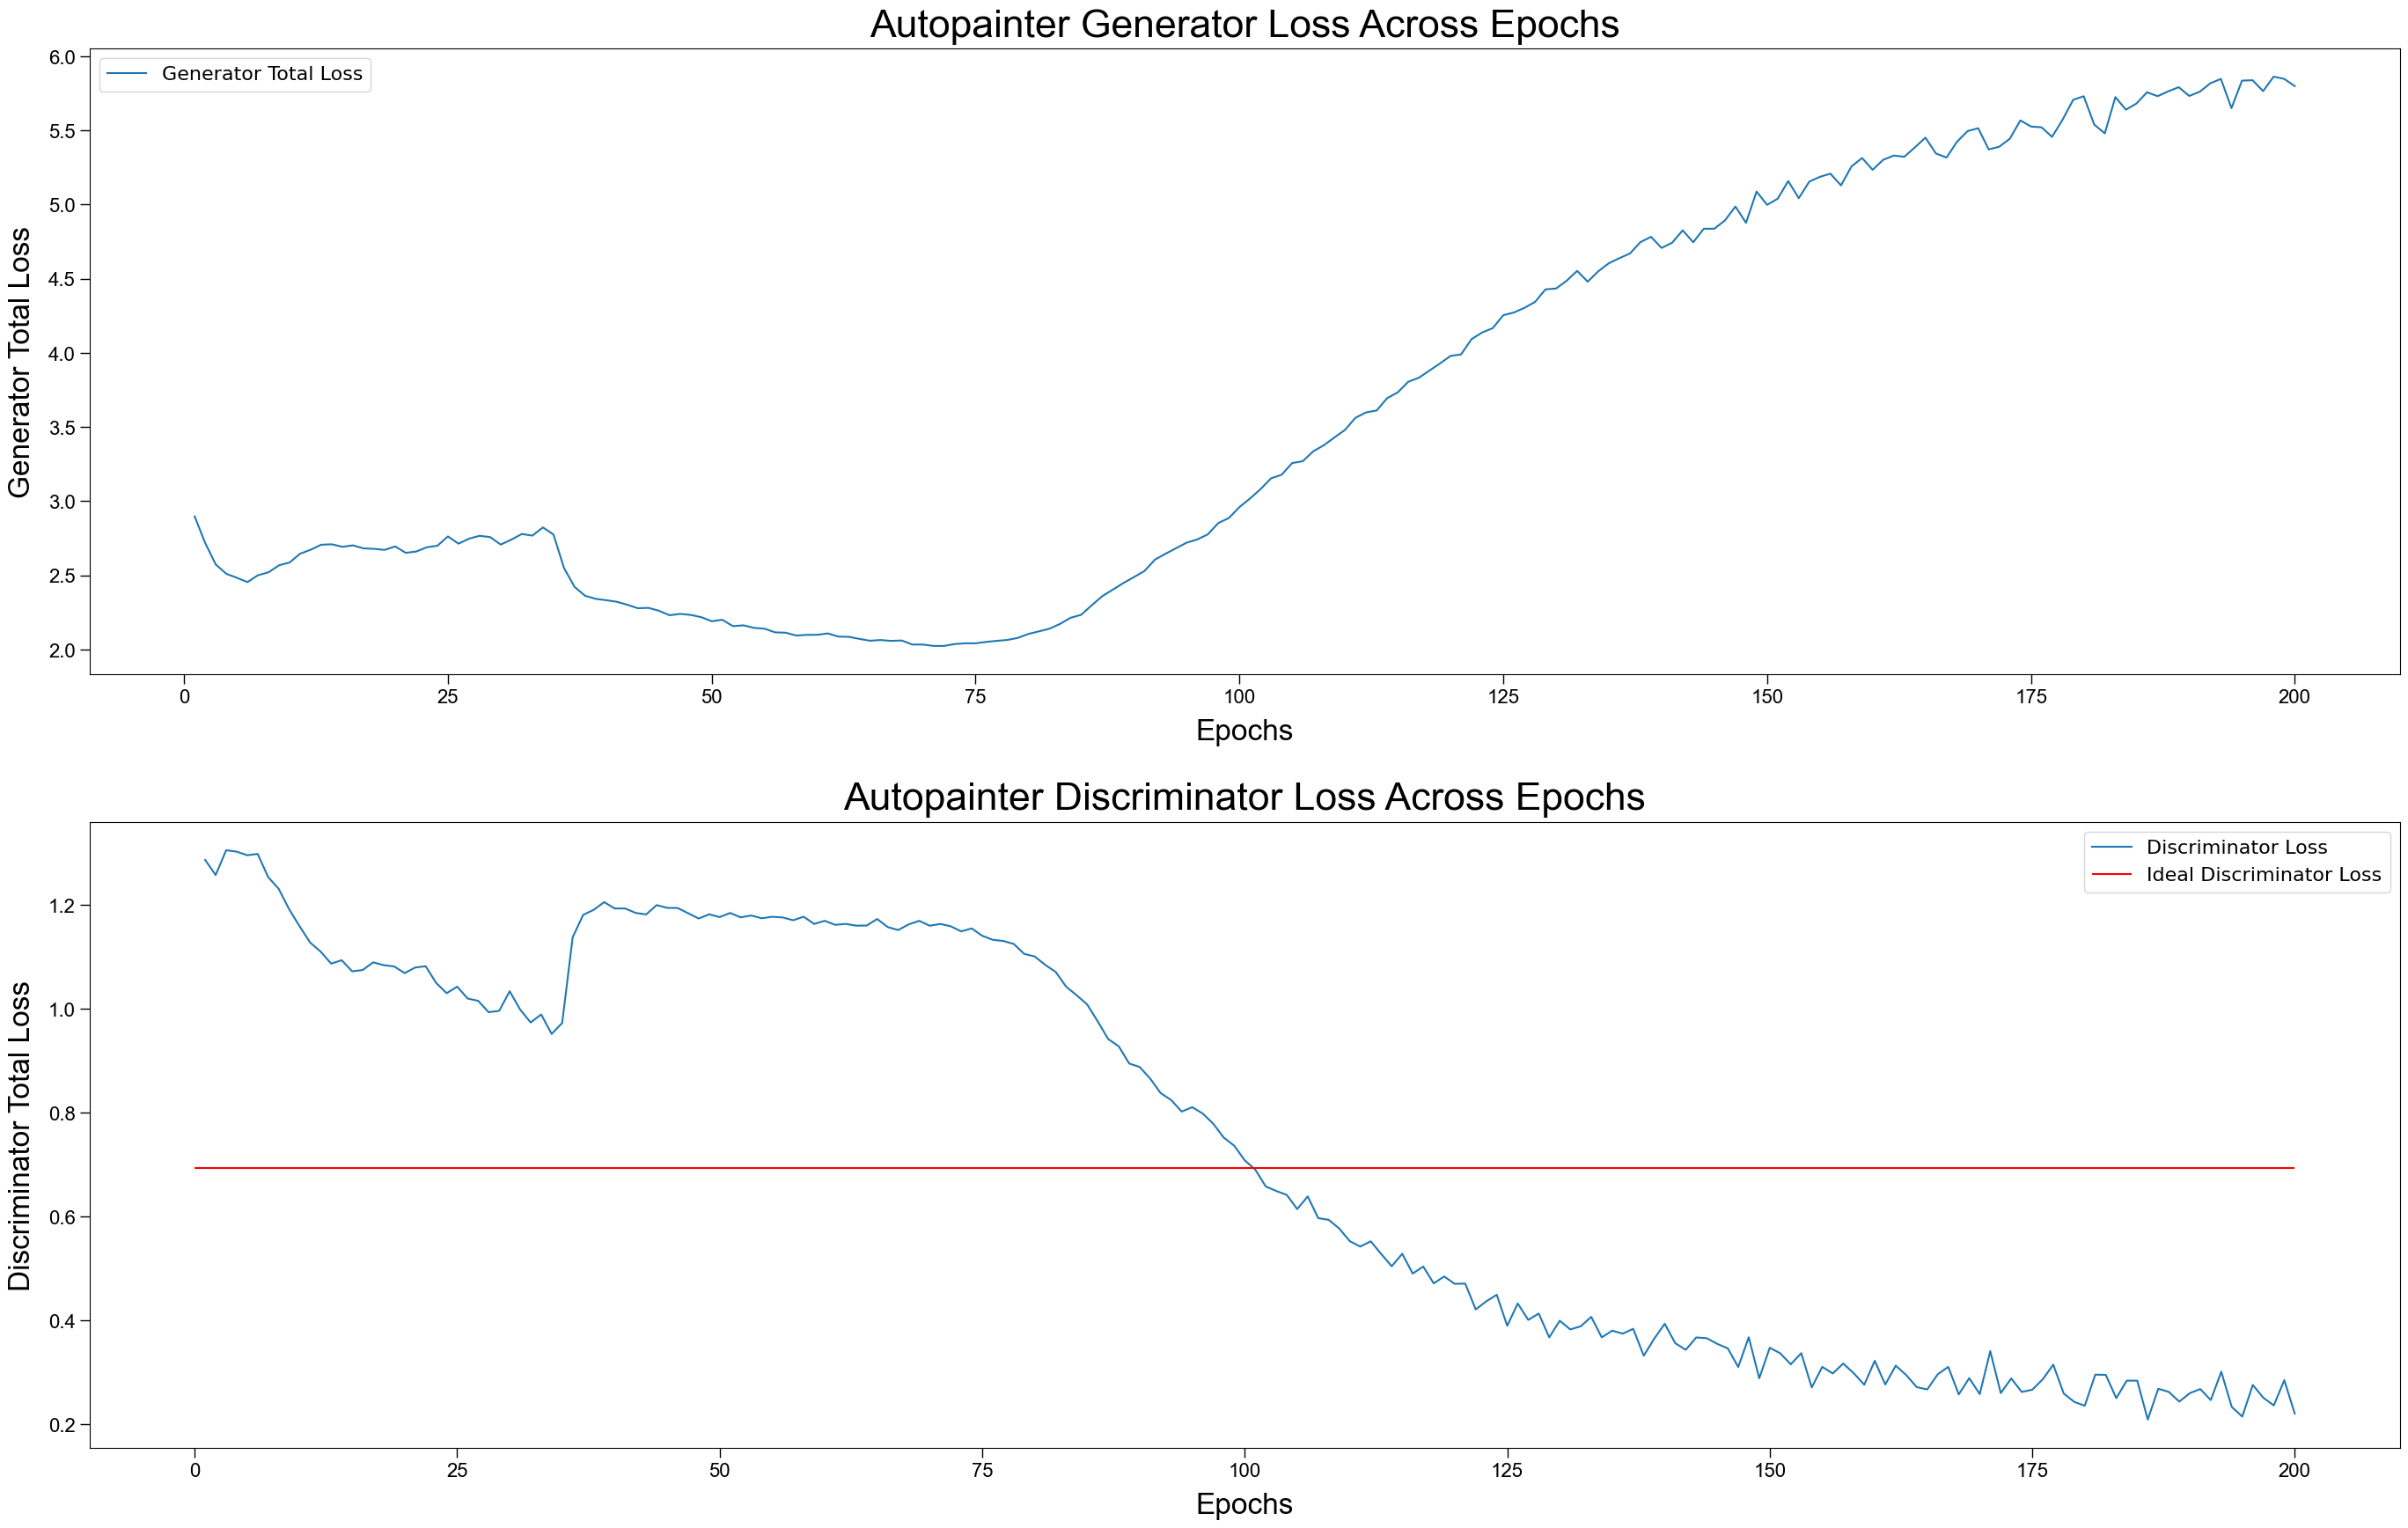

In [22]:
fig = vis.plot_gen_and_disc_losses(autopainter_df, 'Autopainter')
# plt.savefig('../visualizations/model_health/autopainter_losses.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Parse FID Scores

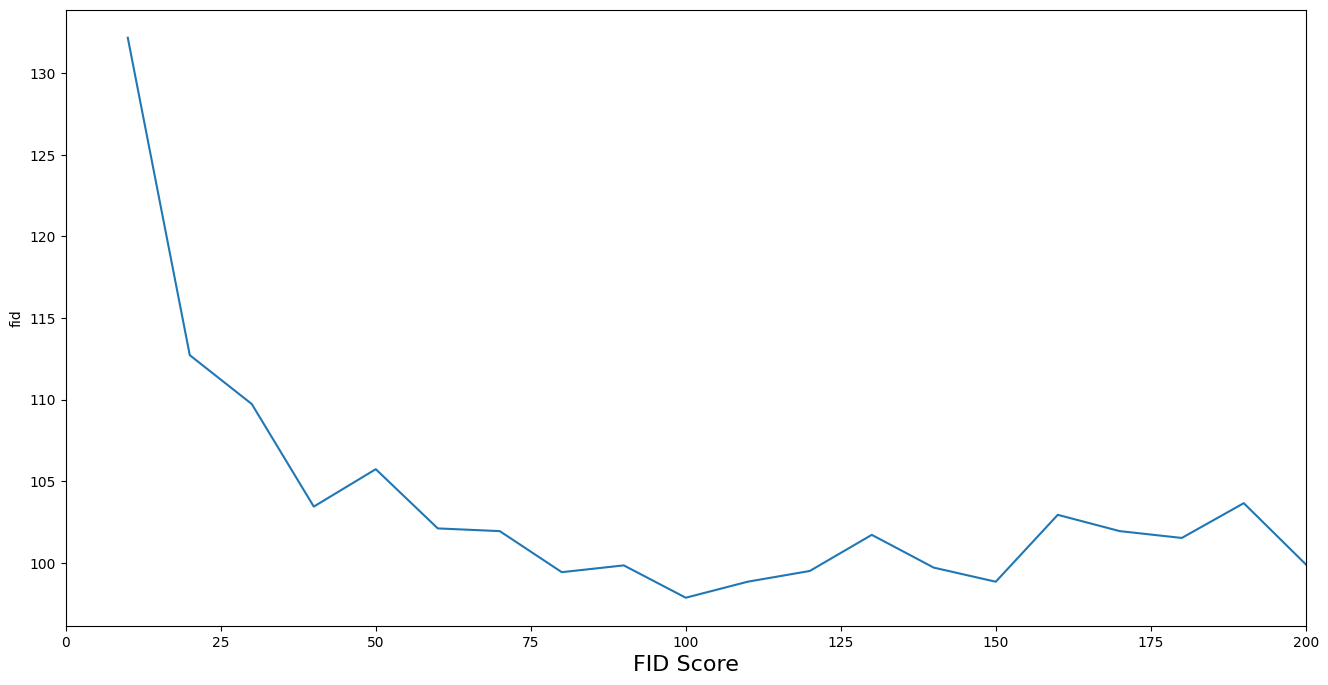

In [8]:
fid_file = '../logs/pix2pix/fid_scores.csv'
pix2pix_fid = logs.parse_fid_logs(fid_file, plot = True)

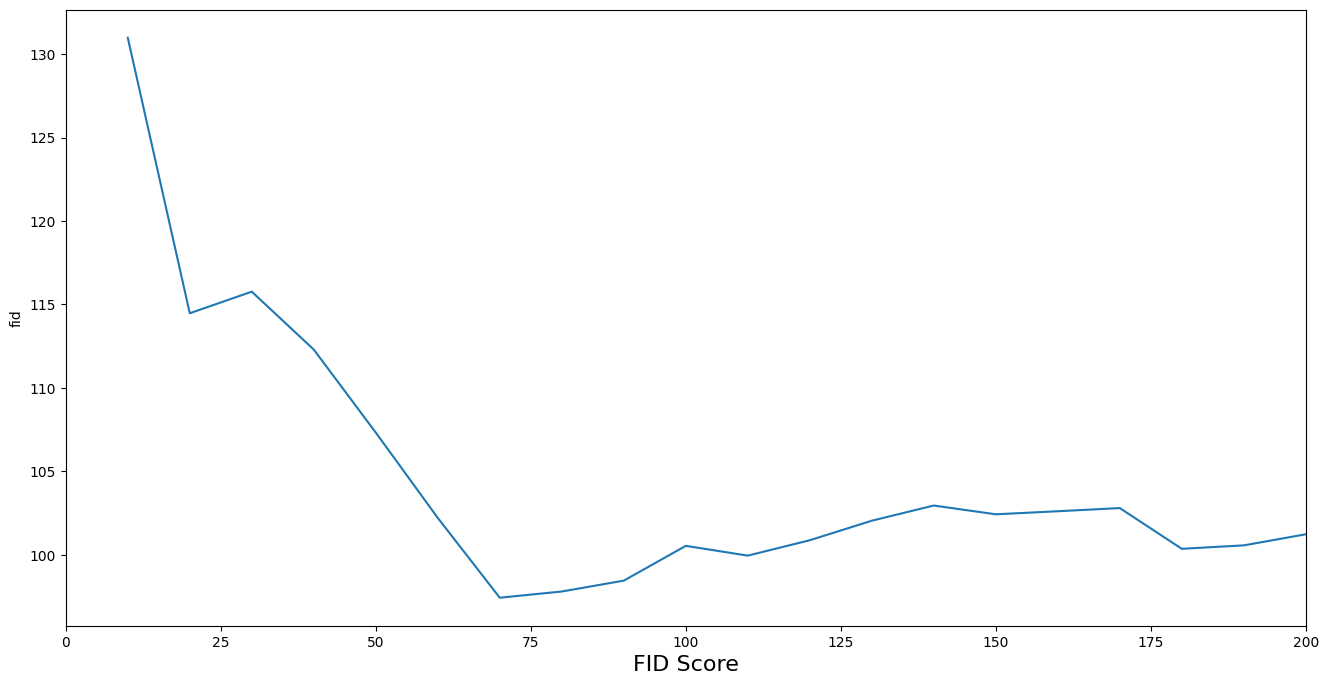

In [9]:
fid_file = '../logs/autopainter/fid_scores.csv'
autopainter_fid = logs.parse_fid_logs(fid_file, plot = True)

In [10]:
merged_fid = autopainter_fid.merge(pix2pix_fid, on = 'epoch', suffixes = ('_autopainter', '_pix2pix'))

In [11]:
autopainter_fid.sort_values('fid')

,epoch,fid
6,70,97.436
7,80,97.809
8,90,98.458
10,110,99.957
17,180,100.366
9,100,100.543
18,190,100.572
11,120,100.879
19,200,101.236
12,130,102.048


In [19]:
merged_fid

,epoch,fid_autopainter,fid_pix2pix
0,10,130.977,132.170
1,20,114.475,112.725
2,30,115.766,109.733
3,40,112.299,103.450
4,50,107.328,105.742
5,60,102.215,102.114
6,70,97.436,101.947
7,80,97.809,99.433
8,90,98.458,99.849
9,100,100.543,97.868


In [13]:
merged_fid.nsmallest(5, 'fid_autopainter')

,epoch,fid_autopainter,fid_pix2pix
6,70,97.436,101.947
7,80,97.809,99.433
8,90,98.458,99.849
10,110,99.957,98.850
17,180,100.366,101.529


In [14]:
merged_fid.nsmallest(5, 'fid_pix2pix')

,epoch,fid_autopainter,fid_pix2pix
9,100,100.543,97.868
14,150,102.433,98.848
10,110,99.957,98.850
7,80,97.809,99.433
11,120,100.879,99.506


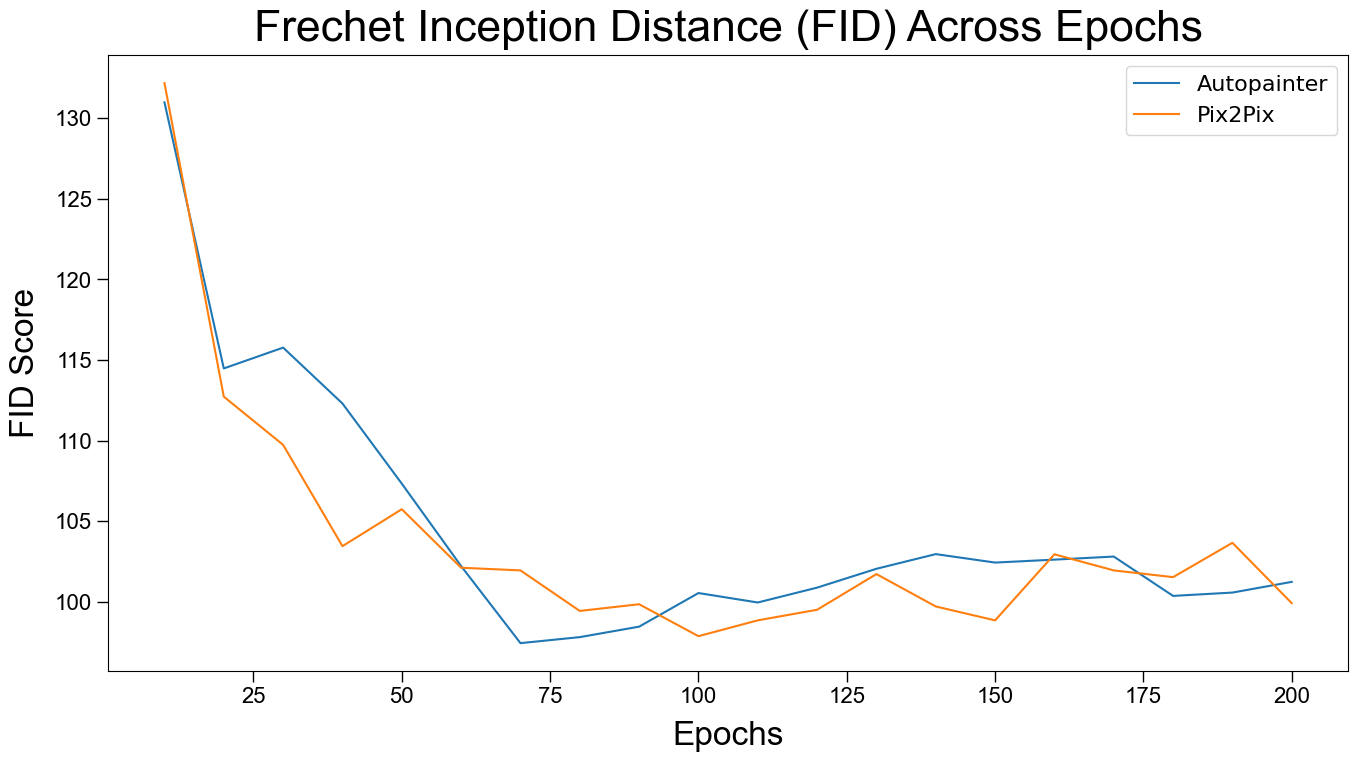

In [20]:
fig = vis.plot_fid_scores(merged_fid)
# plt.savefig('../visualizations/model_health/FID_scores.png', format = 'png', bbox_inches = 'tight')